# Agent-based simulation III (jupyter notebook version)

### Bacterial antibiotic production and degradation in a 3-species community

Based on the paper, "Counteraction of antibiotic production and degradation stabilizes microbial communities", Kelsic et al., 2015. *Nature*. https://doi.org/10.1038/nature14485

The code below is adapted from Mark Grivainis's code from previous years of the course.

Complete the tasks below, and submit homework by **15:45, Tuesday, 10/29**. You are welcome to use chatGPT!

## To complete for this workbook homework

1) ### Recapitulate simulations from the paper, figure 1 findings (4 visualizations - animations or static final frame):
    - With antibiotic production, but no degradation
        - Find a configuration with low dispersal (PROPAGATION_RADIUS), where all species are maintained (1 visualization)
        - Find a configuration with high dispersal, where one species outcompetes all others (1 visualization)
    - With antibiotic production AND antibiotic degradation
        - Find a configuration where you use the same radii of dispersal (PROPAGATION_RADIUS) you used in 1, but this time all 3 species are maintained (2 visualizations)

    Refer to fig. 1e if you the instructions are hard to visualize!


2) ### Implement species-specific behaviour (2 visualizations and short explanation):
    - Show an animation with antibiotic production, where one species dominates
    - Rescue co-existence with antibiotic degradation
    - Briefly explain (2-3 sentences) how these species-specific changes seem to affect the dynamics (versus part 1)

    Example for 2: Species-specific PROPAGATION_RADIUS (radius of dispersal), with a vast difference between species.
    I'd recommend a low initial population (0.001) and more frames (100) to better visualize this specific example.
    How do the dynamics change when there is no co-existence? Does introducing antibiotic degradation stabilize the resulting community? This example would investigate the same question the authours addressed in figure 2.

    (optional alternative) If you have another idea of how you'd like to add to the model (e.g., environmental changes/perturbations, more species, etc.), you are welcome to try it instead of a new species-specific behaviour, and address the tasks listed under 2 for your new model instead.

In [ ]:
!pip install numba

In [ ]:
from functools import wraps # for timer decorator
import numpy as np
from numba import jit # make it fast!
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time


# Use integers for compatibility with Numba
A = 1  # Species A
B = 2  # Species B
C = 3  # Species C

# Timer decorator - this just allows us to time how long functions take to run
def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result
    return measure_time

# Initialize the grid
@jit(nopython=True) # make it fast! (just in time compiler transpiles to C)
def initialize_grid(GRID_W, GRID_H, INIT_POPULATION):
    grid = np.zeros((GRID_W, GRID_H), dtype=np.int32)
    for x in range(GRID_W):
        for y in range(GRID_H):
            state = np.random.random() # random number between 0 and 1 (used to determine where to randomly place cells)
            if state <= INIT_POPULATION: # condition will be true INIT_POPULATION*100% of the time
                grid[y][x] = np.random.randint(1, 4)  # Random species A, B, or C
    return grid

# Function to kill off cells based on antibiotic and degrader radii (cells are cells in space, not bacteria)
@jit(nopython=True)
def kill_off_cells(grid, GRID_W, GRID_H, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS):
    for y in range(GRID_W):
        for x in range(GRID_H):
            total_ab = np.zeros(3, dtype=np.int32)
            total_deg = np.zeros(3, dtype=np.int32)
            for j in range(-MAX_RADIUS, MAX_RADIUS + 1):
                for i in range(-MAX_RADIUS, MAX_RADIUS + 1):
                    dist = i * i + j * j
                    if dist <= (ANTIBIOTIC_RADIUS + 0.5) ** 2:
                        wrapped_y = (y + j) % GRID_H # wrap around the grid (aka periodic boundary conditions)
                        wrapped_x = (x + i) % GRID_W # % takes the remainder of the division: e.g., 201 % 200 = 1
                        if grid[wrapped_y][wrapped_x] == A:
                            total_ab[0] += 1 # each species has a different index in the antibiotic and degrader arrays
                        elif grid[wrapped_y][wrapped_x] == B:
                            total_ab[1] += 1
                        elif grid[wrapped_y][wrapped_x] == C:
                            total_ab[2] += 1
                    if dist <= (DEGRADER_RADIUS + 0.5) ** 2:
                        wrapped_y = (y + j) % GRID_H
                        wrapped_x = (x + i) % GRID_W
                        if grid[wrapped_y][wrapped_x] == A:
                            total_deg[0] += 1 # here, like for the antibiotics, we add a count for each species
                        elif grid[wrapped_y][wrapped_x] == B:
                            total_deg[1] += 1
                        elif grid[wrapped_y][wrapped_x] == C:
                            total_deg[2] += 1
            # Cell killing logic - go back over the grid
            if grid[y][x] == A and (total_deg[1] < 1 <= total_ab[2]):
                grid[y][x] = 0
            elif grid[y][x] == B and (total_deg[2] < 1 <= total_ab[0]):
                grid[y][x] = 0
            elif grid[y][x] == C and (total_deg[0] < 1 <= total_ab[1]):
                grid[y][x] = 0
    return grid

# Function to propagate cells
@jit(nopython=True)
def propagate_cells(grid, grid_new, GRID_W, GRID_H, PROPAGATION_RADIUS):
    for y in range(GRID_W):
        for x in range(GRID_H):
            if grid[y][x] != 0:
                continue
            sp_present = np.zeros(3, dtype=np.int32) # track which species are present in the neighborhood
            for j in range(-PROPAGATION_RADIUS, PROPAGATION_RADIUS + 1):
                for i in range(-PROPAGATION_RADIUS, PROPAGATION_RADIUS + 0.5):
                    if i * i + j * j <= (PROPAGATION_RADIUS + 0.5) ** 2: # check if we are within the circle
                        wrapped_y = (y + j) % GRID_H
                        wrapped_x = (x + i) % GRID_W
                        if grid[wrapped_y][wrapped_x] == A:
                            sp_present[0] = 1
                        elif grid[wrapped_y][wrapped_x] == B:
                            sp_present[1] = 1
                        elif grid[wrapped_y][wrapped_x] == C:
                            sp_present[2] = 1
            if sp_present.any():
                grid_new[y][x] = np.random.choice(np.nonzero(sp_present)[0]) + 1 # pick nearby species at random; add 1 for the actual species identifier
    return grid_new

# Update the grid for the next iteration
@jit(nopython=True)
def update_grid(grid, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS):
    grid = kill_off_cells(grid, GRID_W, GRID_H, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS)
    grid_new = grid.copy()  # Avoid modifying in-place directly
    grid_new = propagate_cells(grid, grid_new, GRID_W, GRID_H, PROPAGATION_RADIUS)
    return grid_new

# Convert grid to RGB for visualization
def to_rgb(grid):
    colored_grid = np.zeros((grid.shape[0], grid.shape[1], 3), dtype=np.float32) # RGB image initialized
    colored_grid[:, :, 0] = (grid == A) # red for species A
    colored_grid[:, :, 1] = (grid == B) # green for species B
    colored_grid[:, :, 2] = (grid == C) # blue for species C
    return colored_grid

# Track population counts (total over time)
def value_count(grid, GRID_W, GRID_H, normalize=False):
    count = np.array([(grid == i).sum() for i in range(4)]) # count the number of cells of each species, i
    if normalize:
        count = count / (GRID_W * GRID_H)
    return count[1:] # ignore 0 (empty cells)

# Main function to run the simulation
@timefn
def run_N(N, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION):
    grid = initialize_grid(GRID_W, GRID_H, INIT_POPULATION)
    cell_count = [] # track populations at each time step
    for i in range(N):
        cell_count.append(value_count(grid, GRID_W, GRID_H, normalize=True))
        grid = update_grid(grid, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS)
    return cell_count, grid

def animate(GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION):
    grid = initialize_grid(GRID_W, GRID_H, INIT_POPULATION)
    counts = [value_count(grid, GRID_W, GRID_H, normalize=True)]

    fig, ax = plt.subplots(2, 1, figsize=(5, 7), gridspec_kw={'height_ratios': [4, 1]})
    im = ax[0].imshow(
        to_rgb(grid),
        aspect="equal",
        interpolation="none",  # sets grid resolution at screen resolution
    )

    c_plot = ax[1].plot(counts)
    [ax[1].lines[i].set_color(color) for i, color in enumerate('rgb')]
    ax[1].set_xlim(0, OUTPUT_FPS * TIME_IN_SEC)
    ax[1].set_ylim(0, 1)

    def update(frame, im, c_plot, grid, counts):
        """Update function for each frame of animation."""
        new_grid = update_grid(grid, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS)
        grid[:] = new_grid[:]  # Update grid in place
        im.set_array(to_rgb(grid))  # Update the image

        # Update the line plot with new counts
        counts.append(value_count(new_grid, GRID_W, GRID_H, normalize=True))
        t_count = np.array(counts)
        for i in range(3):
            c_plot[i].set_data(np.arange(t_count.shape[0]), t_count[:, i])

        return [im] + c_plot  # Return the updated image and plot lines

    ani = FuncAnimation(
        fig,
        update,  # function to pass to FuncAnimation
        fargs=(im, c_plot, grid, counts),
        frames=OUTPUT_FPS * TIME_IN_SEC,
        interval=1000 / OUTPUT_FPS,
        repeat=False,
        blit=True,  # This optimizes redrawing of unchanged parts (speeds it up a bit) - make False if you see weird artifacts
    )

    return ani




### Running the above - 2 ways (animate or final image)

@timefn: run_N took 8.33496356010437 seconds


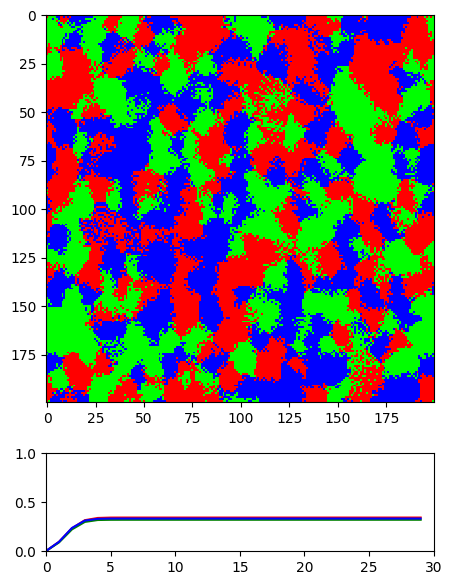

In [ ]:
# Run without abx. Time and show final configuration.

# Set your constants
OUTPUT_FPS = 30
TIME_IN_SEC = 1
GRID_W = 200
GRID_H = 200
INIT_POPULATION = 0.01
PROPAGATION_RADIUS = 3
ANTIBIOTIC_RADIUS = 0
DEGRADER_RADIUS = 0
MAX_RADIUS = max(ANTIBIOTIC_RADIUS, DEGRADER_RADIUS)

# Run the simulation with the updated constants
%matplotlib inline
counts, grid = run_N(OUTPUT_FPS * TIME_IN_SEC, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION)
fig, ax = plt.subplots(2, 1, figsize=(5, 7), gridspec_kw={'height_ratios': [4, 1]})
im = ax[0].imshow(
    to_rgb(grid),
    aspect="equal",
    interpolation="none",  # this sets grid resolution at screen resolution
)
c_plot = ax[1].plot(counts)
[ax[1].lines[i].set_color(color) for i, color in enumerate('rgb')]
ax[1].set_xlim(0, OUTPUT_FPS * TIME_IN_SEC)
ax[1].set_ylim(0, 1)
plt.ion()
plt.show()


In [ ]:
# Add abx. Animate this time.

# Set your constants
OUTPUT_FPS = 30
TIME_IN_SEC = 5
GRID_W = 200
GRID_H = 200
INIT_POPULATION = 0.01
PROPAGATION_RADIUS = 10
ANTIBIOTIC_RADIUS = 5
DEGRADER_RADIUS = 0
MAX_RADIUS = max(ANTIBIOTIC_RADIUS, DEGRADER_RADIUS)

# Call the animate function to create an animation
%matplotlib inline

ani = animate(GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION)
HTML(ani.to_html5_video())


Output hidden; open in https://colab.research.google.com to view.

# Homework Section


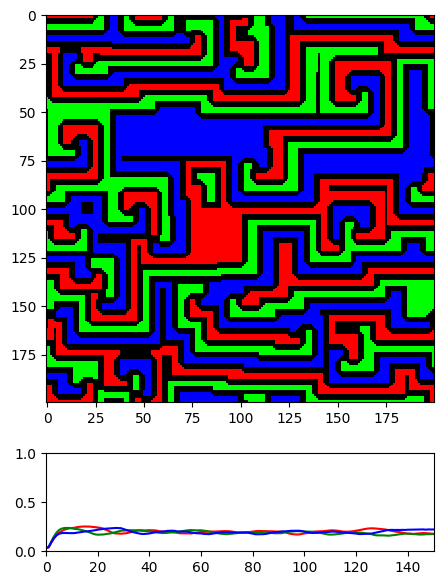

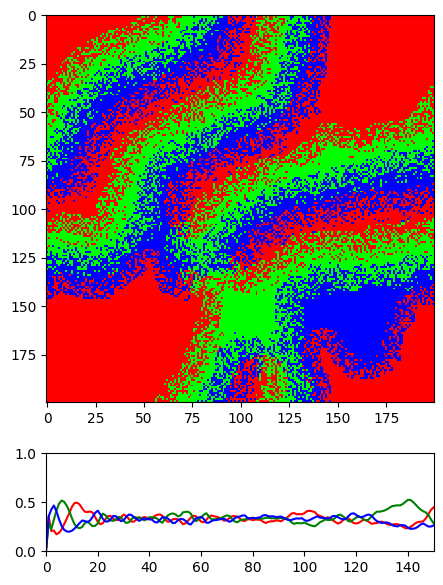

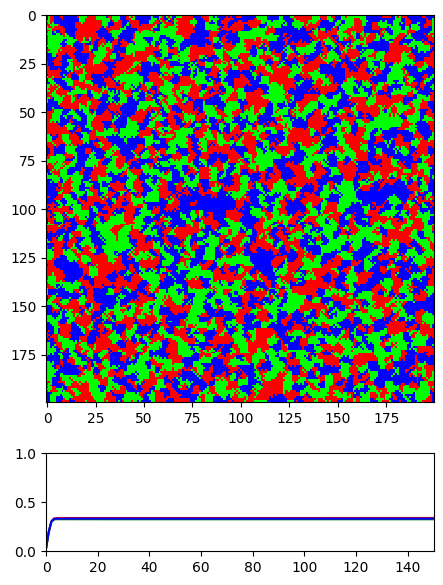

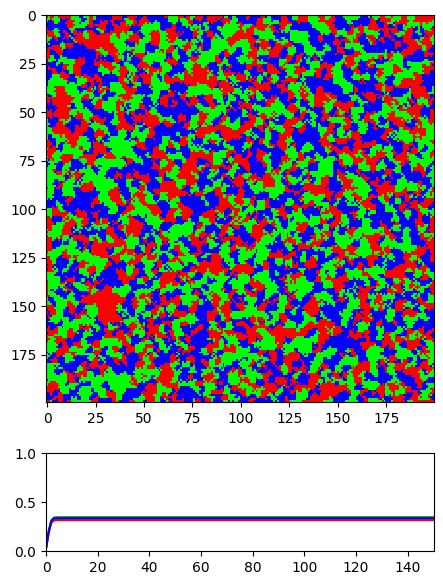

In [ ]:
from functools import wraps  # for timer decorator
import numpy as np
from numba import jit  # make it fast!
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time

# Use integers for compatibility with Numba
A = 1  # Species A
B = 2  # Species B
C = 3  # Species C

# Timer decorator - this just allows us to time how long functions take to run
def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result
    return measure_time

# Initialize the grid
@jit(nopython=True)
def initialize_grid(GRID_W, GRID_H, INIT_POPULATION):
    grid = np.zeros((GRID_W, GRID_H), dtype=np.int32)
    for x in range(GRID_W):
        for y in range(GRID_H):
            state = np.random.random()
            if state <= INIT_POPULATION:
                grid[y][x] = np.random.randint(1, 4)  # Random species A, B, or C
    return grid

# Function to kill off cells based on antibiotic and degrader radii
@jit(nopython=True)
def kill_off_cells(grid, GRID_W, GRID_H, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS):
    for y in range(GRID_W):
        for x in range(GRID_H):
            total_ab = np.zeros(3, dtype=np.int32)
            total_deg = np.zeros(3, dtype=np.int32)
            for j in range(-MAX_RADIUS, MAX_RADIUS + 1):
                for i in range(-MAX_RADIUS, MAX_RADIUS + 1):
                    dist = i * i + j * j
                    if dist <= (ANTIBIOTIC_RADIUS + 0.5) ** 2:
                        wrapped_y = (y + j) % GRID_H
                        wrapped_x = (x + i) % GRID_W
                        if grid[wrapped_y][wrapped_x] == A:
                            total_ab[0] += 1
                        elif grid[wrapped_y][wrapped_x] == B:
                            total_ab[1] += 1
                        elif grid[wrapped_y][wrapped_x] == C:
                            total_ab[2] += 1
                    if dist <= (DEGRADER_RADIUS + 0.5) ** 2:
                        wrapped_y = (y + j) % GRID_H
                        wrapped_x = (x + i) % GRID_W
                        if grid[wrapped_y][wrapped_x] == A:
                            total_deg[0] += 1
                        elif grid[wrapped_y][wrapped_x] == B:
                            total_deg[1] += 1
                        elif grid[wrapped_y][wrapped_x] == C:
                            total_deg[2] += 1
            # Cell killing logic
            if grid[y][x] == A and (total_deg[1] < 1 <= total_ab[2]):
                grid[y][x] = 0
            elif grid[y][x] == B and (total_deg[2] < 1 <= total_ab[0]):
                grid[y][x] = 0
            elif grid[y][x] == C and (total_deg[0] < 1 <= total_ab[1]):
                grid[y][x] = 0
    return grid

# Function to propagate cells
@jit(nopython=True)
def propagate_cells(grid, grid_new, GRID_W, GRID_H, PROPAGATION_RADIUS):
    for y in range(GRID_W):
        for x in range(GRID_H):
            if grid[y][x] != 0:
                continue
            sp_present = np.zeros(3, dtype=np.int32)
            for j in range(-PROPAGATION_RADIUS, PROPAGATION_RADIUS + 1):
                for i in range(-PROPAGATION_RADIUS, PROPAGATION_RADIUS + 1):
                    if i * i + j * j <= (PROPAGATION_RADIUS + 0.5) ** 2:
                        wrapped_y = (y + j) % GRID_H
                        wrapped_x = (x + i) % GRID_W
                        if grid[wrapped_y][wrapped_x] == A:
                            sp_present[0] = 1
                        elif grid[wrapped_y][wrapped_x] == B:
                            sp_present[1] = 1
                        elif grid[wrapped_y][wrapped_x] == C:
                            sp_present[2] = 1
            if sp_present.any():
                grid_new[y][x] = np.random.choice(np.nonzero(sp_present)[0]) + 1
    return grid_new

# Update the grid for the next iteration
@jit(nopython=True)
def update_grid(grid, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS):
    grid = kill_off_cells(grid, GRID_W, GRID_H, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS)
    grid_new = grid.copy()
    grid_new = propagate_cells(grid, grid_new, GRID_W, GRID_H, PROPAGATION_RADIUS)
    return grid_new

# Convert grid to RGB for visualization
def to_rgb(grid):
    colored_grid = np.zeros((grid.shape[0], grid.shape[1], 3), dtype=np.float32)
    colored_grid[:, :, 0] = (grid == A)
    colored_grid[:, :, 1] = (grid == B)
    colored_grid[:, :, 2] = (grid == C)
    return colored_grid

# Track population counts (total over time)
def value_count(grid, GRID_W, GRID_H, normalize=False):
    count = np.array([(grid == i).sum() for i in range(4)])
    if normalize:
        count = count / (GRID_W * GRID_H)
    return count[1:]

# Main function to run the simulation
@timefn
def run_N(N, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION):
    grid = initialize_grid(GRID_W, GRID_H, INIT_POPULATION)
    cell_count = []
    for i in range(N):
        cell_count.append(value_count(grid, GRID_W, GRID_H, normalize=True))
        grid = update_grid(grid, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS)
    return cell_count, grid

def animate(GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION):
    grid = initialize_grid(GRID_W, GRID_H, INIT_POPULATION)
    counts = [value_count(grid, GRID_W, GRID_H, normalize=True)]

    fig, ax = plt.subplots(2, 1, figsize=(5, 7), gridspec_kw={'height_ratios': [4, 1]})
    im = ax[0].imshow(
        to_rgb(grid),
        aspect="equal",
        interpolation="none",
    )

    c_plot = ax[1].plot(counts)
    [ax[1].lines[i].set_color(color) for i, color in enumerate('rgb')]
    ax[1].set_xlim(0, OUTPUT_FPS * TIME_IN_SEC)
    ax[1].set_ylim(0, 1)

    def update(frame, im, c_plot, grid, counts):
        """Update function for each frame of animation."""
        new_grid = update_grid(grid, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS)
        grid[:] = new_grid[:]  # Update grid in place
        im.set_array(to_rgb(grid))  # Update the image

        counts.append(value_count(new_grid, GRID_W, GRID_H, normalize=True))
        t_count = np.array(counts)
        for i in range(3):
            c_plot[i].set_data(np.arange(t_count.shape[0]), t_count[:, i])

        return [im] + c_plot

    ani = FuncAnimation(
        fig,
        update,
        fargs=(im, c_plot, grid, counts),
        frames=OUTPUT_FPS * TIME_IN_SEC,
        interval=1000 / OUTPUT_FPS,
        repeat=False,
        blit=True,
    )

    return ani

# Simulation 1: With Antibiotic Production, but No Degradation
# Set your constants
OUTPUT_FPS = 30
TIME_IN_SEC = 5
GRID_W = 200
GRID_H = 200
INIT_POPULATION = 0.1  # Higher initial population to help maintain species
PROPAGATION_RADIUS = 1  # Low dispersal
ANTIBIOTIC_RADIUS = 5   # Antibiotic production
DEGRADER_RADIUS = 0      # No degradation
MAX_RADIUS = max(ANTIBIOTIC_RADIUS, DEGRADER_RADIUS)

# Call the animate function for simulation 1
ani1 = animate(GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION)
HTML(ani1.to_html5_video())

# Simulation 2: High Dispersal, One Species Outcompetes All Others
# Set your constants
INIT_POPULATION = 0.05  # Lower initial population
PROPAGATION_RADIUS = 10  # High dispersal
ANTIBIOTIC_RADIUS = 5    # Antibiotic production
DEGRADER_RADIUS = 0       # No degradation
MAX_RADIUS = max(ANTIBIOTIC_RADIUS, DEGRADER_RADIUS)

# Call the animate function for simulation 2
ani2 = animate(GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION)
HTML(ani2.to_html5_video())

# Simulation 3: With Antibiotic Production AND Antibiotic Degradation
# Set your constants
INIT_POPULATION = 0.1  # Higher initial population
PROPAGATION_RADIUS = 1  # Low dispersal
ANTIBIOTIC_RADIUS = 5   # Antibiotic production
DEGRADER_RADIUS = 5      # Antibiotic degradation
MAX_RADIUS = max(ANTIBIOTIC_RADIUS, DEGRADER_RADIUS)

# Call the animate function for simulation 3
ani3 = animate(GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION)
HTML(ani3.to_html5_video())

# Simulation 4: With Antibiotic Production AND Antibiotic Degradation (Same Radii as in #1)
# Set your constants (similar to the previous one)
OUTPUT_FPS = 30
TIME_IN_SEC = 5
INIT_POPULATION = 0.1  # Higher initial population
PROPAGATION_RADIUS = 1  # Low dispersal
ANTIBIOTIC_RADIUS = 5   # Antibiotic production
DEGRADER_RADIUS = 5      # Antibiotic degradation
MAX_RADIUS = max(ANTIBIOTIC_RADIUS, DEGRADER_RADIUS)

# Call the animate function for simulation 4
ani4 = animate(GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION)
HTML(ani4.to_html5_video())


In [ ]:
from functools import wraps  # for timer decorator
import numpy as np
from numba import jit  # make it fast!
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time

# Use integers for compatibility with Numba
A = 1  # Species A
B = 2  # Species B
C = 3  # Species C

# Timer decorator - this just allows us to time how long functions take to run
def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result
    return measure_time

# Initialize the grid
@jit(nopython=True)
def initialize_grid(GRID_W, GRID_H, INIT_POPULATION):
    grid = np.zeros((GRID_W, GRID_H), dtype=np.int32)
    for x in range(GRID_W):
        for y in range(GRID_H):
            state = np.random.random()  # random number between 0 and 1
            if state <= INIT_POPULATION:  # condition for placement
                grid[y][x] = np.random.randint(1, 4)  # Random species A, B, or C
    return grid

# Function to kill off cells based on antibiotic and degrader radii
@jit(nopython=True)
def kill_off_cells(grid, GRID_W, GRID_H, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS):
    for y in range(GRID_W):
        for x in range(GRID_H):
            total_ab = np.zeros(3, dtype=np.int32)
            total_deg = np.zeros(3, dtype=np.int32)
            for j in range(-MAX_RADIUS, MAX_RADIUS + 1):
                for i in range(-MAX_RADIUS, MAX_RADIUS + 1):
                    dist = i * i + j * j
                    if dist <= (ANTIBIOTIC_RADIUS + 0.5) ** 2:
                        wrapped_y = (y + j) % GRID_H
                        wrapped_x = (x + i) % GRID_W
                        if grid[wrapped_y][wrapped_x] == A:
                            total_ab[0] += 1
                        elif grid[wrapped_y][wrapped_x] == B:
                            total_ab[1] += 1
                        elif grid[wrapped_y][wrapped_x] == C:
                            total_ab[2] += 1
                    if dist <= (DEGRADER_RADIUS + 0.5) ** 2:
                        wrapped_y = (y + j) % GRID_H
                        wrapped_x = (x + i) % GRID_W
                        if grid[wrapped_y][wrapped_x] == A:
                            total_deg[0] += 1
                        elif grid[wrapped_y][wrapped_x] == B:
                            total_deg[1] += 1
                        elif grid[wrapped_y][wrapped_x] == C:
                            total_deg[2] += 1
            # Cell killing logic
            if grid[y][x] == A and (total_deg[1] < 1 <= total_ab[2]):
                grid[y][x] = 0
            elif grid[y][x] == B and (total_deg[2] < 1 <= total_ab[0]):
                grid[y][x] = 0
            elif grid[y][x] == C and (total_deg[0] < 1 <= total_ab[1]):
                grid[y][x] = 0
    return grid

# Function to propagate cells
@jit(nopython=True)
def propagate_cells(grid, grid_new, GRID_W, GRID_H, PROPAGATION_RADIUS):
    for y in range(GRID_W):
        for x in range(GRID_H):
            if grid[y][x] != 0:
                continue
            sp_present = np.zeros(3, dtype=np.int32)  # track species presence
            for j in range(-PROPAGATION_RADIUS, PROPAGATION_RADIUS + 1):
                for i in range(-PROPAGATION_RADIUS, PROPAGATION_RADIUS + 1):
                    if i * i + j * j <= (PROPAGATION_RADIUS + 0.5) ** 2:
                        wrapped_y = (y + j) % GRID_H
                        wrapped_x = (x + i) % GRID_W
                        if grid[wrapped_y][wrapped_x] == A:
                            sp_present[0] = 1
                        elif grid[wrapped_y][wrapped_x] == B:
                            sp_present[1] = 1
                        elif grid[wrapped_y][wrapped_x] == C:
                            sp_present[2] = 1
            if sp_present.any():
                grid_new[y][x] = np.random.choice(np.nonzero(sp_present)[0]) + 1
    return grid_new

# Update the grid for the next iteration
@jit(nopython=True)
def update_grid(grid, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS):
    grid = kill_off_cells(grid, GRID_W, GRID_H, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS)
    grid_new = grid.copy()
    grid_new = propagate_cells(grid, grid_new, GRID_W, GRID_H, PROPAGATION_RADIUS)
    return grid_new

# Convert grid to RGB for visualization
def to_rgb(grid):
    colored_grid = np.zeros((grid.shape[0], grid.shape[1], 3), dtype=np.float32)
    colored_grid[:, :, 0] = (grid == A)  # red for species A
    colored_grid[:, :, 1] = (grid == B)  # green for species B
    colored_grid[:, :, 2] = (grid == C)  # blue for species C
    return colored_grid

# Track population counts (total over time)
def value_count(grid, GRID_W, GRID_H, normalize=False):
    count = np.array([(grid == i).sum() for i in range(4)])
    if normalize:
        count = count / (GRID_W * GRID_H)
    return count[1:]  # ignore 0 (empty cells)

# Main function to run the simulation
@timefn
def run_N(N, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION):
    grid = initialize_grid(GRID_W, GRID_H, INIT_POPULATION)
    cell_count = []
    for i in range(N):
        cell_count.append(value_count(grid, GRID_W, GRID_H, normalize=True))
        grid = update_grid(grid, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS)
    return cell_count, grid

# Animate function for visualization
def animate(GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION):
    grid = initialize_grid(GRID_W, GRID_H, INIT_POPULATION)
    counts = [value_count(grid, GRID_W, GRID_H, normalize=True)]

    fig, ax = plt.subplots(2, 1, figsize=(5, 7), gridspec_kw={'height_ratios': [4, 1]})
    im = ax[0].imshow(
        to_rgb(grid),
        aspect="equal",
        interpolation="none",
    )

    c_plot = ax[1].plot(counts)
    [ax[1].lines[i].set_color(color) for i, color in enumerate('rgb')]
    ax[1].set_xlim(0, 100)
    ax[1].set_ylim(0, 1)

    def update(frame, im, c_plot, grid, counts):
        new_grid = update_grid(grid, GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS)
        grid[:] = new_grid[:]  # Update grid in place
        im.set_array(to_rgb(grid))  # Update the image

        # Update the line plot with new counts
        counts.append(value_count(new_grid, GRID_W, GRID_H, normalize=True))
        t_count = np.array(counts)
        for i in range(3):
            c_plot[i].set_data(np.arange(t_count.shape[0]), t_count[:, i])

        return [im] + c_plot

    ani = FuncAnimation(
        fig,
        update,
        fargs=(im, c_plot, grid, counts),
        frames=100,
        interval=1000 / 30,
        repeat=False,
        blit=True,
    )

    return ani

# Simulation 1: Antibiotic Production with Dominance
GRID_W = 200
GRID_H = 200
INIT_POPULATION = 0.001  # Low initial population
PROPAGATION_RADIUS = 5    # Moderate dispersal
ANTIBIOTIC_RADIUS = 5     # Antibiotic production
DEGRADER_RADIUS = 0        # No degradation
MAX_RADIUS = max(ANTIBIOTIC_RADIUS, DEGRADER_RADIUS)

# Call the animate function for simulation 1
ani1 = animate(GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION)
plt.title("Antibiotic Production with Dominance")
HTML(ani1.to_jshtml())

# Simulation 2: Rescue Coexistence with Antibiotic Degradation
GRID_W = 200
GRID_H = 200
INIT_POPULATION = 0.001  # Low initial population
PROPAGATION_RADIUS = 5    # Moderate dispersal
ANTIBIOTIC_RADIUS = 5     # Antibiotic production
DEGRADER_RADIUS = 5        # Antibiotic degradation to rescue coexistence
MAX_RADIUS = max(ANTIBIOTIC_RADIUS, DEGRADER_RADIUS)

# Call the animate function for simulation 2
ani2 = animate(GRID_W, GRID_H, PROPAGATION_RADIUS, ANTIBIOTIC_RADIUS, DEGRADER_RADIUS, MAX_RADIUS, INIT_POPULATION)
plt.title("Rescue Coexistence with Antibiotic Degradation")
HTML(ani2.to_jshtml())


Output hidden; open in https://colab.research.google.com to view.

The dynamics with no co-existance may have a dominant species take over the grid or take up spaces in higher densities compared to the others. There might also be some unstabilitiy found within the grid space that changes over time to probably lead to total species elimination due to lack of diversity.

Adding antibiotics to the system may add more stability with a degrader by eliminating their overall effects on each other allowing the other species to co-exist together. Essentially the balance of is restored in the system and there is more opportunity for the other species to fluctuate in size and density.